# Imports

In [476]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.build_features import *
from src.visualization.visualize import *
import seaborn as sns
output_notebook()
# set font size 
plt.rcParams.update({'font.size': 16})

from datetime import timedelta
from matplotlib.ticker import MaxNLocator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [29]:
# transition from acceptable to unhealthy for sensitive group and to unhealthy. 
transition_dict = { 'PM2.5': [0, 35.5, 55.4, 1e3],
                  'PM10': [0, 155, 254, 1e3],
                  'O3':[0, 70 , 85, 1e3],
                  'SO2':[0, 75, 185, 1e3],
                  'NO2': [0, 100, 360, 1e3],
                  'CO': [0, 6.4, 12.5, 1e3]}

gas_list = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2']

city_info = {'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok'}

x = merc_x(city_info['Longitude'])
y = merc_y(city_info['Latitude'])

In [7]:
b_folder='../data/pm25/'
a4th_folder ='../data/air4thai_hourly/'
cm_folder ='../data/cm_proc/'
cdc_folder = '../data/cdc_data/'
aqm_folder = '../data/aqm_hourly2/'

In [105]:
aqm1 = pd.read_csv(cm_folder + '35t.csv').set_index('datetime').dropna(how='all')
aqm1.index = pd.to_datetime(aqm1.index)
aqm2 = pd.read_csv(cm_folder + '36t.csv').set_index('datetime').dropna(how='all')
aqm2.index = pd.to_datetime(aqm2.index)
print(aqm2.columns)
# keep only the data after the satallite data which is 200-11-11 13 am
aqm2_01 = aqm2[aqm2.index>='2000-11-01 00:00:00'].copy()
aqm2_01 = add_season(aqm2_01)
print(aqm2_01.shape)

# weather data 
filename = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/data/weather_cities/Mueang_Chiang_Mai.csv'
wea = pd.read_csv(filename)
wea.drop(['Time','Dew Point(C)','Wind Gust(kmph)','Pressure(in)','Precip.(in)'], axis=1, inplace=True)
wea['datetime'] = pd.to_datetime(wea['datetime'])
# merge with weather 

aqm2_01 = aqm2_01.merge(wea, left_index=True, right_on ='datetime',how='inner').set_index('datetime')
print(aqm2_01.shape)

Index(['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5'], dtype='object')
(168169, 8)
(165291, 13)


In [377]:
fire = pd.read_csv('C:/Users/Benny/Documents/Fern/aqi_thailand2/data/cm_proc/file_m_proc.csv')
fire['datetime'] = pd.to_datetime(fire['datetime'])
fire = fire.set_index('datetime')
fire.head()

,confidence,lat_km,long_km,distance,power,count
datetime,,,,,,
2002-07-04 13:03:00,67,1612.0,11453.0,665.551109,120.96,1
2002-07-04 13:04:00,52,2246.0,11701.0,694.254989,20.52,1
2002-07-04 13:04:00,48,2304.0,11682.0,689.069015,13.50,1
2002-07-04 13:04:00,91,2305.0,11682.0,689.341767,132.30,1
2002-07-04 13:05:00,62,2428.0,11936.0,968.527252,10.45,1


# Feature Engineering Functions

In [249]:
# function for feature eng fire
def cal_power_damp(series: pd.core.series.Series, distance: pd.core.series.Series, surface='sphere'):
    """ Calculate the damped power based on the distance series. 

    The damping factor maybe 1/distance or 1/distance**2.
    Args: 
        series: series to recalculate
        distance: distance array. Must have the same lenght as the series
        surface(optional): either 'circle' or 'sphere'

    Returns:
        new_series

    Examples:
        cal_power_damp(fire['power'], fire['distance'],surface='sphere')

    """
    if surface == 'sphere':
        new_series = series/distance**2

    elif surface == 'circle':
        new_series = series/distance

    return new_series


def cal_arrival_time(detection_time: pd.core.series.Series, distance: pd.core.series.Series, wind_speed: (float, np.array) = 2):
    """ Calculate the approximate time that the pollution arrived at the city using the wind speed and distance from the hotspot.

    Round arrival time to hour 

    Args:
        detection_time: datetime series
        distance: distance series in km
        wind_speed(optional): approximate wind speed, can be floar or array in km/hour

    Returns: 
        arrival_time: datetime series of arrival time

    """
    arrival_time = detection_time + pd.to_timedelta(distance/wind_speed, 'h')
    return arrival_time.dt.round('H')


def shift_fire(fire_df: pd.core.frame.DataFrame, fire_col: str = 'power', damp_surface: str = 'sphere', shift: int = 0, roll: int = 48, w_speed: (float, int) = 8):
    """ Feature engineer fire data. Account of the distance from the source and time lag using wind speed.

    Args:
        fire_df:
        fire_col
        damp_surface
        shift
        roll

    """
    require_cols = ['distance', fire_col]
    if fire_df.columns.isin(require_cols).sum() > len(require_cols):
        raise AssertionError(
            'missing required columns for feature engineering fire data')

    # calculate the damping factors
    fire_df['damp_'+fire_col] = cal_power_damp(
        fire_df[fire_col], fire_df['distance'], surface=damp_surface)
    # calculate particle arrival time
    fire_df['arrival_time'] = cal_arrival_time(
        detection_time=fire_df.index, distance=fire_df['distance'], wind_speed=w_speed)
    fire_df = fire_df.set_index('arrival_time')
    fire_df = fire_df.resample('h').sum()['damp_'+fire_col]
    fire_df = fire_df.rolling(roll).sum()
    fire_df = fire_df.shift(shift)
    fire_df.index.name = 'datetime'
    return fire_df


def get_fire_feature(fire, zone_list=[0, 100, 200, 400, 800, 1000], fire_col: str = 'power', damp_surface: str = 'sphere', shift: int = 0, roll: int = 48, w_speed: (float, int) = 8):
    """ Separate fire from different distance

    """
    fire_col_list = []
    new_fire = pd.DataFrame()
    for start, stop in zip(zone_list, zone_list[1:]):
        col_name = f'fire_{start}_{stop}'

        fire_col_list.append(col_name)
        # select sub-data baseline the distance
        fire_s = fire[(fire['distance'] < stop) & (fire['distance'] >= start)][[fire_col, 'distance']].copy()
        fire_s = shift_fire(fire_s, fire_col=fire_col, damp_surface=damp_surface,
                            shift=shift, roll=roll, w_speed=w_speed)
        fire_s.name = col_name
        new_fire = pd.concat([new_fire, fire_s], axis=1, ignore_index=False)

    new_fire = new_fire.fillna(0)
    return new_fire, fire_col_list

def sep_fire_zone(fire, fire_col, zone_list=[0, 100, 200, 400, 800, 1000]):
    """ Separate fire data into zone mark by a distance in the zone_list without perform feature enginering.
    Use for data visualization
    
    Args: 
        fire: fire dataframe
        fire_col: 'power' or 'count'
        zone_list:
        
    Return: 
        new_fire: a dataframe with each column, a fire data in that zone
        fire_col_list: a list of column name
    
    """
    fire_col_list = []
    new_fire = pd.DataFrame()
    for start, stop in zip(zone_list, zone_list[1:]):
        col_name = f'fire_{start}_{stop}'
        fire_col_list.append(col_name)
        # select sub-data baseline the distance
        fire_s = fire[(fire['distance'] < stop) & (fire['distance'] >= start)][[fire_col]].copy()
        fire_s.columns = [col_name]
        fire_s = fire_s.resample('h').sum()
        new_fire = pd.concat([new_fire, fire_s], axis=1, ignore_index=False)

    return new_fire, fire_col_list

In [500]:
def split_data_index(data_index, shuffle=False,val_size=0.3, test_size=0.25):
    trn, test = train_test_split(data_index, test_size=test_size, shuffle=False)
    trn, val  = train_test_split(trn, test_size=val_size, shuffle=False)
    print('train size', len(trn))
    print('validation size',len(val))
    print('test size',len(test))
    return trn,  val, test

def get_data_matrix(data, pollutant,use_index, x_cols=None):
    """Extract data in data dataframe into x,y matricies using use_index.
    
    """
    temp = data.loc[use_index]
    
    y = temp[pollutant].values
    
    if x_cols==None:
        x = temp.drop(pollutant,axis=1)
    else:
        x = temp[x_cols]
        
    x_cols = x.columns
    return x.values, y, x_cols
    
# get data 
def get_data(data, pollutant:str,x_cols=None, shuffle=False, val_size=0.3, test_size=0.25):
    """Obtain xtrn, ytrn, xval, yval, xtest, ytest
    
    Args:
        data: data dataframe
        pollutant: name of the pollutant ex. 'PM2.5'
        x_cols(optional): a list of input columns
        shuffle(optional): suffle split the data
        val_size: size of validation split
        test_size: size of test split 
    
    """
    y = data[pollutant]
    if x_cols==None:
        x = data.drop(pollutant,axis=1)
    else:
        x = data[x_cols]
        
    x_cols = x.columns
    data_index = x.index

    trn_idx, val_idx, test_idx = split_data_index(data_index,shuffle=shuffle, val_size=val_size, test_size=test_size)
    ytrn = y.loc[trn_idx].values
    xtrn = x.loc[trn_idx].values

    yval = y.loc[val_idx].values
    xval = x.loc[val_idx].values

    ytest = y.loc[test_idx].values
    xtest = x.loc[test_idx].values
    
    index_list = [trn_idx,val_idx,test_idx]
    
    return xtrn, ytrn, xval, yval, xtest, ytest, index_list, x_cols

In [416]:
# Add AutoRegressive Feature

# calculate number of lag 
def find_num_lag(poll_series, thres=0.5):
    """ Calculate the numbers of partial autocorrelation lag to add as feature to a time series. 
    
    """

    pac = pacf(poll_series)
    # find the number of lag 
    idxs = np.where(pac >= 0.5)[0]
    return idxs[1:]

def add_lags(data, pollutant):
    """Add lags columns to x_data.

    """
    # calculate num lags
    num_lags = find_num_lag(data[pollutant])
    for idx in num_lags:
        lag_name = f'{pollutant}_lag_{idx}'
        lag_series = data[pollutant].shift(idx) 
        lag_series.name = lag_name
        # add to data 
        data = pd.concat([data, lag_series], axis=1) 
    data = data.dropna()
    return data

# Model PM2.5

Workflow for full feature engineering
1. Create fire features:
    parameters: fire_col, damp_surface, shift, roll, wind_speed, zone_list 
2. One hot encode wind columns for major wind directions (CLAM, N, E, W, S)
3. Add rain boolean column
4. Add information related to calendar: holiday, weekend, time of day, day of week
5. Calculate the number of lag and add lag columns 

 




In [378]:
## Featuare Eng Fires

# fire feature engineering parameters 
# fire column either 'power' or 'count'
fire_col = 'power'
# surface damping factor
damp_surface = 'sphere'
# shifting of the data
shift = 0
# rolling average parameter (in hour)
roll = 48
# effective wind speed (km/h)
w_speed = 8

fire_proc, fire_col_list = get_fire_feature(fire, zone_list=[0, 100, 200, 400, 800, 1000], 
                        fire_col=fire_col,damp_surface=damp_surface, 
                        shift=shift, roll=roll, w_speed=w_speed)
print(fire_col_list)

['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_800', 'fire_800_1000']


(0, 12)

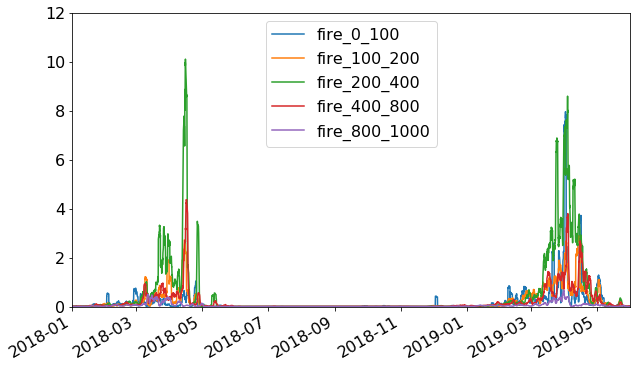

In [252]:
fire_proc[fire_col_list].plot(figsize=(10,6))
plt.xlim(['2018', '2019-06'])
plt.ylim([0,12])

In [525]:
# load the data and keep only relavant data 
pollutant = 'PM2.5'
cols = [pollutant, 'Temperature(C)', 'Humidity(%)', 'Wind', 'Wind Speed(kmph)', 'Condition']
data = aqm2_01[cols].dropna()

if pollutant == 'PM2.5':
    data = data.loc['2010':]

# add weather 
dummies = wind_to_dummies(data['Wind'])
data.drop('Wind',axis=1, inplace=True)
data = pd.concat([data, dummies], axis=1)
data = add_is_rain(data)
data = add_calendar_info(data)
data = add_lags(data, pollutant)
data_no_fire = data.astype(float)

# inner joint fire with pm data
print('data before merge has shape', data.shape)
data = data_no_fire.merge(fire_proc, left_index=True, right_index=True, how='inner')
data = data.dropna()
print('data after merge has shape', data.shape)

print(data.columns)
print('number of columns', len(data.columns))

data before merge has shape (74600, 15)
data after merge has shape (73941, 20)
Index(['PM2.5', 'Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)',
       'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W', 'is_rain',
       'is_holiday', 'is_weekend', 'day_of_week', 'time_of_day', 'PM2.5_lag_1',
       'fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_800',
       'fire_800_1000'],
      dtype='object')
number of columns 20


# Hierarcal relationship among features and Highly Correlated Columns

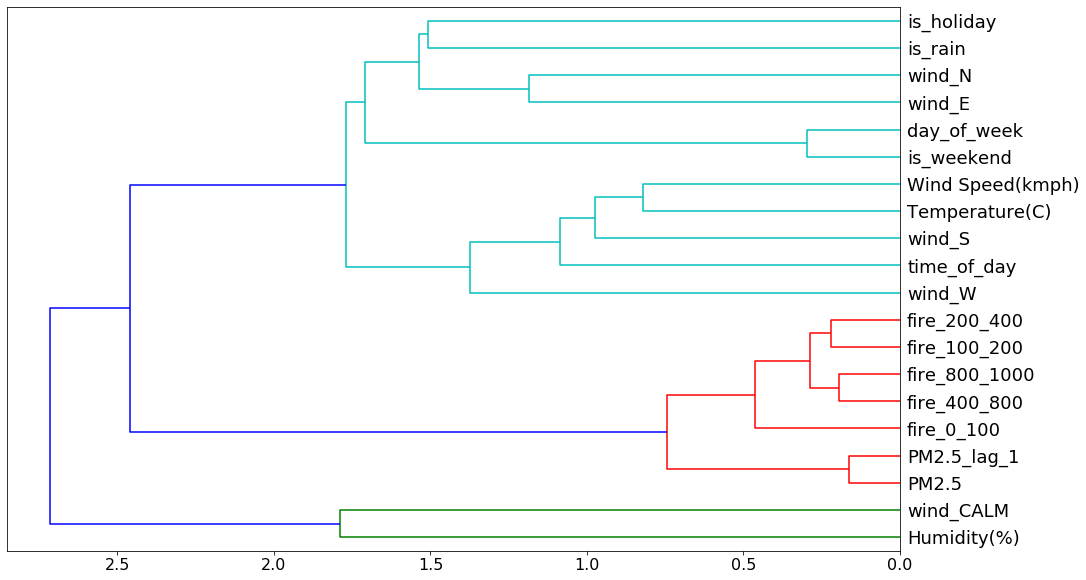

In [462]:
ax = plot_dendogram(data,front_size=18)

In [467]:
def find_high_corr_pair(data, x_cols, thres = 0.7):
    """Find highly correlated columns to later drop.
    
    Returns: 2D numpy array of two highly correlation columns and their correlation values. 
    """

    high_corr_list = []
    corr_mat = data.corr('spearman').abs()
    # find highly correlated pairs
    for col1, col2 in combinations(x_cols, 2):
        cor_value = corr_mat.loc[col1,col2]
        if cor_value>= thres:
            high_corr_list.append([col1, col2, cor_value])
            
    return high_corr_list

In [470]:
x_cols = data.drop(pollutant, axis=1).columns
high_corr_list = find_high_corr_pair(data, x_cols, thres = 0.7)
high_corr_list

[['Wind Speed(kmph)', 'wind_CALM', 0.7440470814020276],
 ['fire_0_100', 'fire_100_200', 0.7170139723912583],
 ['fire_0_100', 'fire_200_400', 0.747887827673642],
 ['fire_0_100', 'fire_400_800', 0.7079757850575487],
 ['fire_0_100', 'fire_800_1000', 0.7027736819822249],
 ['fire_100_200', 'fire_200_400', 0.8728102331380816],
 ['fire_100_200', 'fire_400_800', 0.8112715087144022],
 ['fire_100_200', 'fire_800_1000', 0.7668008645985953],
 ['fire_200_400', 'fire_400_800', 0.8923703103774102],
 ['fire_200_400', 'fire_800_1000', 0.8241493942797838],
 ['fire_400_800', 'fire_800_1000', 0.8806203704993413],
 ['is_weekend', 'day_of_week', 0.790412635036172]]

# Split the data

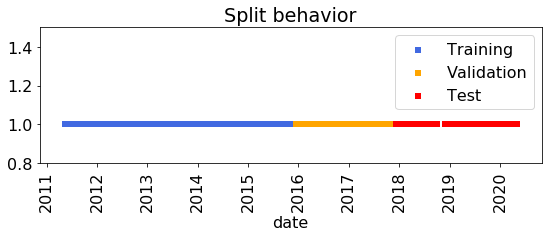

In [420]:
display_time_split(trn_idx, val_idx, test_idx)

In [507]:
# split data index 
# because will be building new feature later in the pipeline, therefore only need index here.
trn_idx, val_idx, test_idx = split_data_index(data.index,shuffle=False, val_size=0.4, test_size=0.3)
# split furture for rf 
trn_rf_idx, val_rf_idx = train_test_split(trn_idx,test_size=0.35)

print('internal split for rf & fire feature', len(trn_rf_idx), len(val_rf_idx))

# obtain xtrn_rf and xval_rf
xtrn_rf, ytrn_rf, x_cols = get_data_matrix(data, pollutant,trn_rf_idx, x_cols=None)
xval_rf, yval_rf, _ = get_data_matrix(data, pollutant,val_rf_idx, x_cols=None)

train size 31054
validation size 20704
test size 22183
internal split for rf & fire feature 20185 10869


# RF Feature of Important Search

In [331]:
def do_rf_search(x_trn,y_trn, cv_split='time', n_splits=5):
    ''' Randomize search for randomforest regressor
    return the best estimator 
    
    '''
    # rf 
    m = RandomForestRegressor(n_jobs=-1, random_state=42)
    
    param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10, 20], 
              'max_features' : range(2,x_trn.shape[1]),
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}
    
    if cv_split =='time':
        cv = TimeSeriesSplit(n_splits=n_splits)
        
    else:
        cv = n_splits
    #hyper parameter tuning
    search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=cv, random_state=40)
    
    search.fit(x_trn,y_trn)
    print(search.best_params_, search.best_score_)
    
    return search.best_estimator_

In [508]:
%%time
# search using normal split 
best_rf_shuffle = do_rf_search(xtrn_rf, ytrn_rf,cv_split=None, n_splits=5)
print(cal_scores(ytrn_rf, best_rf_shuffle.predict(xtrn_rf), header_str ='trn_'))
val_score_shuffle = cal_scores(yval_rf, best_rf_shuffle.predict(xval_rf), header_str ='val_')
print(val_score_shuffle)
val_score_shuffle = val_score_shuffle['val_mean_squared_error']

# search using time split 
best_rf_time  = do_rf_search(xtrn_rf, ytrn_rf,cv_split='time', n_splits=5)
print(cal_scores(ytrn_rf, best_rf.predict(xtrn_rf), header_str ='trn_'))
val_score_time = cal_scores(yval_rf, best_rf_time.predict(xval_rf), header_str ='val_')
print(val_score_time)
val_score_time = val_score_time['val_mean_squared_error']

if val_score_shuffle < val_score_time:
    print('shuffle is better')
    best_rf = best_rf_shuffle
else:
    print('time split is better')
    best_rf = best_rf_time

print(best_rf.get_params())

{'n_estimators': 160, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 7, 'max_depth': None, 'bootstrap': True} 0.8374674704519762


ValueError: Number of features of the model must match the input. Model n_features is 14 and input n_features is 19 

# Hunt for the best fire features

For each fire zone. It need proper surface damping factor, timelag, shift and rolling sum, and windspeed. To do that, split the training data further and

In [518]:
from itertools import product

In [538]:
def get_fire_hyperparams():
    fire_col = ['power','count']
    surface_list = ['sphere','circle']
    w_speed_list = np.arange(6, 20, 4)

    shift_list = np.arange(-24, 24+12, 12)
    roll_list = np.arange(0, 72+24, 24)

    params_list = [*product(fire_col, surface_list, w_speed_list, shift_list, roll_list)]

    cols =['fire_col','surface','w_speed','shift', 'roll']
    params_df = pd.DataFrame(params_list,columns=cols)
    return params_df

In [539]:
 
def search_fire_hyper(model, data_no_fire,fire, pollutant, params_df,trn_index,val_index):
    """ Search for the best fire feature engineering parameters. 
    
    Args:
        model:
        data_no_fire
        fire:
        pollutant:
        params_df:
        trn_index:
        val_index:
    
    """
    temp_data = data_no_fire.loc[trn_index.append(val_index)]
    search_fire = pd.DataFrame()
    
    for i, params in tqdm(params_df.iterrows()): 
        result_dict = params.to_dict()
        fire_col = result_dict['fire_col']
        w_speed = result_dict['w_speed']
        damp_surface = result_dict['surface']
        shift = result_dict['shift']
        roll = result_dict['roll']
        # obtain fire data 
        fire_proc, fire_col_list = get_fire_feature(fire, zone_list=[0, 100, 200, 400, 800, 1000], 
                        fire_col=fire_col,damp_surface=damp_surface, 
                        shift=shift, roll=roll, w_speed=w_speed)
        print('sharpe before merge', temp_data.shape)
        # merge fire data 
        data = temp_data.merge(fire_proc, left_index=True, right_index=True, how='inner')
        data = data.dropna()
        print('sharpe after merge', data.shape)
    
        xtrn_temp, ytrn_temp, _ = get_data_matrix(data, pollutant,trn_index, x_cols=None)
        xval_temp, yval_temp, _ = get_data_matrix(data, pollutant,val_index, x_cols=None)
    
        model.fit(xtrn_temp, ytrn_temp)
        score = cal_scores(ytrn_temp, rf.predict(xtrn_temp), header_str ='trn_')
        result_dict.update(score)
        score = cal_scores(yval_temp, rf.predict(xval_temp), header_str ='val_')
        result_dict.update(score)
    
        search_fire = pd.concat([search_fire, pd.DataFrame(result_dict, index=[i] )])
    
    search_fire = search_fire.sort_values('val_mean_square_error')
    
    return search_fire
    

In [ ]:
rf = RandomForestRegressor(n_estimators=160, min_samples_split=10, min_samples_leaf=6, 
                           max_features=7, max_depth=None, bootstrap=True)

params_df = get_fire_hyperparams()
print(params_df.shape)
search_fire_df = search_fire_hyper(rf, data_no_fire, fire, pollutant, params_df, trn_rf_idx, val_rf_idx )
search_fire_df.head()



0it [00:00, ?it/s]

(320, 5)




1it [00:11, 11.99s/it]

2it [00:27, 12.92s/it]

3it [00:41, 13.52s/it]

4it [00:57, 14.01s/it]

5it [01:09, 13.38s/it]

6it [01:24, 14.00s/it]

7it [01:39, 14.34s/it]

8it [01:54, 14.51s/it]

9it [02:06, 13.69s/it]

10it [02:21, 14.06s/it]

11it [02:36, 14.32s/it]

12it [02:51, 14.51s/it]

13it [03:02, 13.69s/it]

14it [03:17, 14.03s/it]

15it [03:35, 15.07s/it]

16it [03:50, 15.23s/it]

17it [04:02, 14.31s/it]

18it [04:18, 14.61s/it]

19it [04:33, 14.77s/it]

20it [04:48, 14.95s/it]

21it [05:00, 14.04s/it]

22it [05:15, 14.39s/it]

23it [05:31, 14.83s/it]

24it [05:48, 15.29s/it]

25it [06:00, 14.44s/it]

26it [06:16, 14.80s/it]

27it [06:31, 14.91s/it]

28it [06:46, 15.10s/it]

29it [06:58, 14.18s/it]

30it [07:14, 14.53s/it]

31it [07:30, 14.91s/it]

32it [07:45, 15.12s/it]

33it [07:58, 14.28s/it]

34it [08:13, 14.72s/it]

35it [08:29, 15.01s/it]

36it [08:45, 15.22s/it]

37it [08:57, 14.45s/it]

38it [09:14, 15.08s/it]

39it [09:29, 15.13s/it]

40it [09:45, 15.29s/it]

41it [0

# Feature of Importance

In [369]:
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame(importances, index=data_cols, columns=[
                        'importance']) 
feat_imp = feat_imp.sort_values('importance').reset_index()
feat_imp

,index,importance
0,is_rain,0.000475
1,wind_N,0.001953
2,wind_CALM,0.002054
3,wind_W,0.002908
4,wind_E,0.002982
5,wind_S,0.003068
6,Wind Speed(kmph),0.023206
7,Temperature(C),0.034807
8,Humidity(%),0.045767
9,fire_800_1000,0.140561


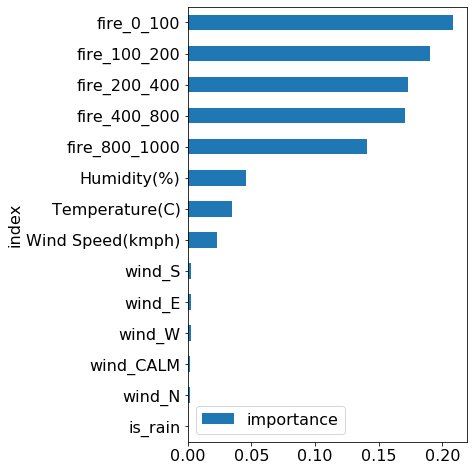

In [368]:
feat_imp.plot('index','importance',kind='barh',figsize=(5,8))